# Executive summary

Summary of this notebook

ES TBD

# Setup

In [248]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import unicodedata
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures

# Manipulation

In [249]:
# Data frame from web scraping
df = pd.read_pickle('result_mod.pkl')

In [250]:
df.sample(5)

,State,Overall_score,Quality_rank,Safety_rank,Salary,Income,Budget,Number_of_incarceration,Percent_SMI,Percent_poverty,Overall_score_H,Percent_married,log_percent_SMI,log_incarceration,log_salary,log_budget,log_income
42,Alaska,38.20,47,43,68138,73355,18414,940,4.1,11.4,40.64,45,1.410987,6.845880,11.129290,9.820867,11.203066
29,Missouri,50.94,25,36,48293,50238,9876,950,5.2,15.5,51.59,43,1.648659,6.856462,10.785042,9.197863,10.824527
22,Ohio,53.51,22,24,57000,51075,11354,780,5.2,15.8,57.57,45,1.648659,6.659294,10.950807,9.337325,10.841050
45,WestVirginia,35.42,46,47,45701,42019,11260,660,6.1,18.3,49.47,41,1.808289,6.492240,10.729875,9.329012,10.645877
10,Illinois,58.32,9,21,61602,59588,13077,700,4.4,14.3,58.51,49,1.481605,6.551080,11.028450,9.478610,10.995209


In [251]:
df['log_log_salary']=np.log(df.log_salary)


In [252]:
df.corr()

,Overall_score,Quality_rank,Safety_rank,Salary,Income,Budget,Number_of_incarceration,Percent_SMI,Percent_poverty,Overall_score_H,Percent_married,log_percent_SMI,log_incarceration,log_salary,log_budget,log_income,log_log_salary
Overall_score,1.000000,-0.870543,-0.798956,0.397292,0.559595,0.379418,-0.627074,-0.131972,-0.718104,0.672950,0.704728,-0.120643,-0.619010,0.408091,0.390309,0.586579,0.408969
Quality_rank,-0.870543,1.000000,0.488974,-0.361223,-0.498897,-0.465702,0.616553,-0.027035,0.676407,-0.642890,-0.662595,-0.034926,0.610636,-0.379961,-0.487839,-0.515545,-0.381569
Safety_rank,-0.798956,0.488974,1.000000,-0.202369,-0.405059,-0.138569,0.442733,0.209957,0.539715,-0.504480,-0.484275,0.192594,0.447747,-0.214440,-0.153783,-0.440118,-0.215541
Salary,0.397292,-0.361223,-0.202369,1.000000,0.648897,0.758127,-0.454299,-0.177429,-0.412568,0.310051,0.397297,-0.181829,-0.441029,0.996260,0.741649,0.650667,0.995550
Income,0.559595,-0.498897,-0.405059,0.648897,1.000000,0.602636,-0.551058,-0.365149,-0.851151,0.594387,0.691589,-0.385579,-0.528633,0.657461,0.590733,0.996464,0.657925
Budget,0.379418,-0.465702,-0.138569,0.758127,0.602636,1.000000,-0.517864,-0.214484,-0.510921,0.336213,0.364298,-0.225807,-0.531544,0.761666,0.987415,0.592591,0.761618
Number_of_incarceration,-0.627074,0.616553,0.442733,-0.454299,-0.551058,-0.517864,1.000000,-0.058711,0.692920,-0.771355,-0.746797,-0.040202,0.980900,-0.465845,-0.532297,-0.566055,-0.466733
Percent_SMI,-0.131972,-0.027035,0.209957,-0.177429,-0.365149,-0.214484,-0.058711,1.000000,0.199595,-0.084646,-0.062378,0.993603,-0.061865,-0.170402,-0.225947,-0.359468,-0.169637
Percent_poverty,-0.718104,0.676407,0.539715,-0.412568,-0.851151,-0.510921,0.692920,0.199595,1.000000,-0.751678,-0.834091,0.215854,0.661258,-0.434811,-0.513524,-0.864656,-0.436592
Overall_score_H,0.672950,-0.642890,-0.504480,0.310051,0.594387,0.336213,-0.771355,-0.084646,-0.751678,1.000000,0.792286,-0.105507,-0.751174,0.321140,0.365304,0.619221,0.321960


## Splitting up my 3 different 'y' terms

Break up the Overall_score, Quality_rank, Safety_rank. They are related to each other and quite correlated

In [274]:
df_overall_score = df.drop(['Quality_rank','Safety_rank','log_incarceration','log_percent_SMI','Percent_SMI','Salary','log_salary','Budget','Income'],1)
df_overall_score = df_overall_score.drop(['log_log_salary','log_budget'],1)
df_overall_score = df_overall_score.set_index('State')

In [275]:
df_quality_rank = df.drop(['Overall_score','Safety_rank'],1)
df_quality_rank = df_quality_rank.set_index('State')

In [276]:
df_safety_rank = df.drop(['Quality_rank','Overall_score'],1)
df_safety_rank = df_safety_rank.set_index('State')

In [277]:
df_overall_score.corr()

,Overall_score,Number_of_incarceration,Percent_poverty,Overall_score_H,Percent_married,log_income
Overall_score,1.000000,-0.627074,-0.718104,0.672950,0.704728,0.586579
Number_of_incarceration,-0.627074,1.000000,0.692920,-0.771355,-0.746797,-0.566055
Percent_poverty,-0.718104,0.692920,1.000000,-0.751678,-0.834091,-0.864656
Overall_score_H,0.672950,-0.771355,-0.751678,1.000000,0.792286,0.619221
Percent_married,0.704728,-0.746797,-0.834091,0.792286,1.000000,0.717546
log_income,0.586579,-0.566055,-0.864656,0.619221,0.717546,1.000000


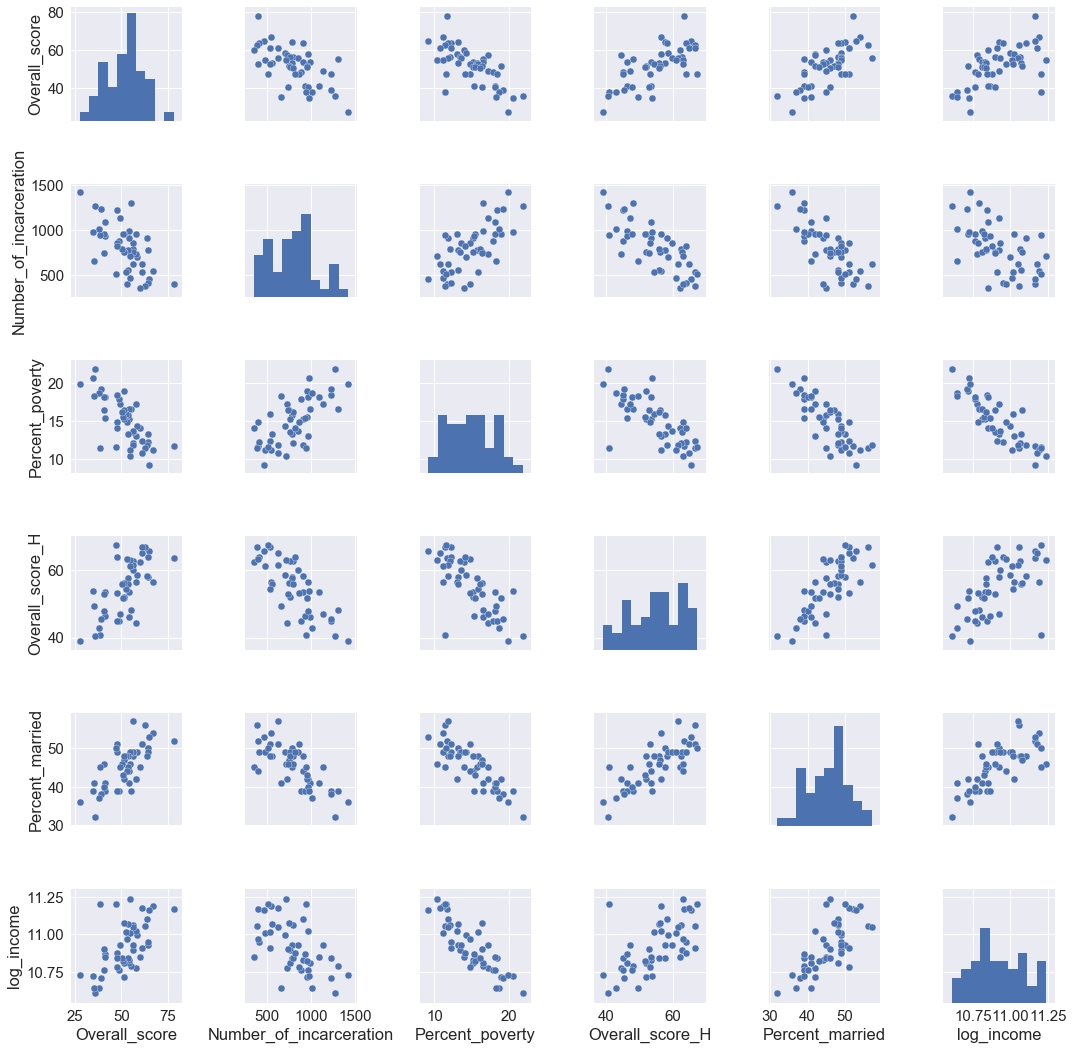

In [278]:
sns.set(font_scale=1.5)
sns.pairplot(df_overall_score)

## Polynomial terms

In [279]:
# test poly interactions and relationships with overall score

p = PolynomialFeatures(degree=2).fit(df_overall_score.drop('Overall_score',1))
features = pd.DataFrame(p.transform(df_overall_score.drop('Overall_score',1)), 
                        index = df_overall_score.index, 
                        columns=p.get_feature_names(df_overall_score.drop('Overall_score',1).columns))
features = features.reset_index(level=0)
features.rename(columns = {'index' : 'State'}, inplace = True)

In [280]:
features = pd.merge(features,df[['Overall_score','State']],on='State')
features.sample(5)

,State,1,Number_of_incarceration,Percent_poverty,Overall_score_H,Percent_married,log_income,Number_of_incarceration^2,Number_of_incarceration Percent_poverty,Number_of_incarceration Overall_score_H,...,Percent_poverty Overall_score_H,Percent_poverty Percent_married,Percent_poverty log_income,Overall_score_H^2,Overall_score_H Percent_married,Overall_score_H log_income,Percent_married^2,Percent_married log_income,log_income^2,Overall_score
3,Wisconsin,1.0,780.0,13.2,57.80,50.0,10.926622,608400.0,10296.0,45084.0,...,762.960,660.0,144.231406,3340.8400,2890.00,631.558734,2500.0,546.331085,119.391062,64.25
34,SouthDakota,1.0,820.0,14.1,63.89,49.0,10.878368,672400.0,11562.0,52389.8,...,900.849,690.9,153.384987,4081.9321,3130.61,695.018925,2401.0,533.040027,118.338888,47.40
30,Michigan,1.0,790.0,16.2,55.82,46.0,10.841227,624100.0,12798.0,44097.8,...,904.284,745.2,175.627871,3115.8724,2567.72,605.157270,2116.0,498.696424,117.532195,50.55
12,NorthCarolina,1.0,730.0,17.2,44.45,42.0,10.775408,532900.0,12556.0,32448.5,...,764.540,722.4,185.337023,1975.8025,1866.90,478.966901,1764.0,452.567150,116.109425,57.68
28,Montana,1.0,760.0,15.2,52.01,48.0,10.809910,577600.0,11552.0,39527.6,...,790.552,729.6,164.310628,2705.0401,2496.48,562.223406,2304.0,518.875668,116.854149,51.40


In [281]:
#fdf = features.corr().sort_values(by=['Overall_score'])

Make x and y data frames

In [282]:
y = features.Overall_score
x = features.drop(['Overall_score','State'],1)

# Linear Regression - Overall score data

In [291]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

## OLS analysis

In [292]:
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Overall_score   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     3.005
Date:                Tue, 24 Apr 2018   Prob (F-statistic):             0.0129
Time:                        20:12:47   Log-Likelihood:                -112.93
No. Observations:                  38   AIC:                             267.9
Df Residuals:                      17   BIC:                             302.2
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
1                                        1.438e+04   2.37e+04      0.607      0.552   -3.56e+04    6.44e+04
Number_of_incarceration                    -0.8440      1.475     -0.572      0.575      -3.956       2.268
Percent_poverty                            19.9631    236.428      0.084      0.934    -478.857     518.783
Overall_score_H                            20.8973     58.340      0.358      0.725    -102.189     143.983
Percent_married                           -74.2165    112.472     -0.660      0.518    -311.511     163.078
log_income                              -2354.7769   4151.919     -0.567      0.578   -1.11e+04    6405.007
Number_of_incarceration^2                2.742e-05   5.89e-05      0.465      0.648   -9.69e-05       0.000
Number_of_incarceration Percent_poverty    -0.0092      0.008     -1.090      0.291      -0.027       0.009
Number_of_incarceration Overall_score_H    -0.0009      0.003     -0.319      0.754      -0.007       0.005
Number_of_incarceration Percent_married    -0.0032      0.004     -0.717      0.483      -0.012       0.006
Number_of_incarceration log_income          0.1032      0.130      0.791      0.440      -0.172       0.379
Percent_poverty^2                          -0.4072      0.998     -0.408      0.688      -2.512       1.698
Percent_poverty Overall_score_H            -0.1944      0.334     -0.581      0.569      -0.900       0.511
Percent_poverty Percent_married            -0.2819      0.780     -0.362      0.722      -1.927       1.363
Percent_poverty log_income                  1.8829     18.469      0.102      0.920     -37.082      40.848
Overall_score_H^2                          -0.0990      0.085     -1.171      0.258      -0.277       0.079
Overall_score_H Percent_married             0.0366      0.211      0.174      0.864      -0.408       0.481
Overall_score_H log_income                 -0.7435      4.639     -0.160      0.875     -10.531       9.044
Percent_married^2                          -0.2302      0.161     -1.432      0.170      -0.569       0.109
Percent_married log_income                  9.1919      9.348      0.983      0.339     -10.530      28.914
log_income^2                               84.1645    187.632      0.449      0.659    -311.705     480.034
==============================================================================
Omnibus:                        4.393   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                3.373
Skew:                           0.401   Prob(JB):                        0.185
Kurtosis:                       4.220   Cond. No.                     1.76e+10
==============================================================================

Warnings:
[1] St

## Ridge analysis

/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0185061937932802e-18 / 1.1102230246251565e-16
  RuntimeWarning)


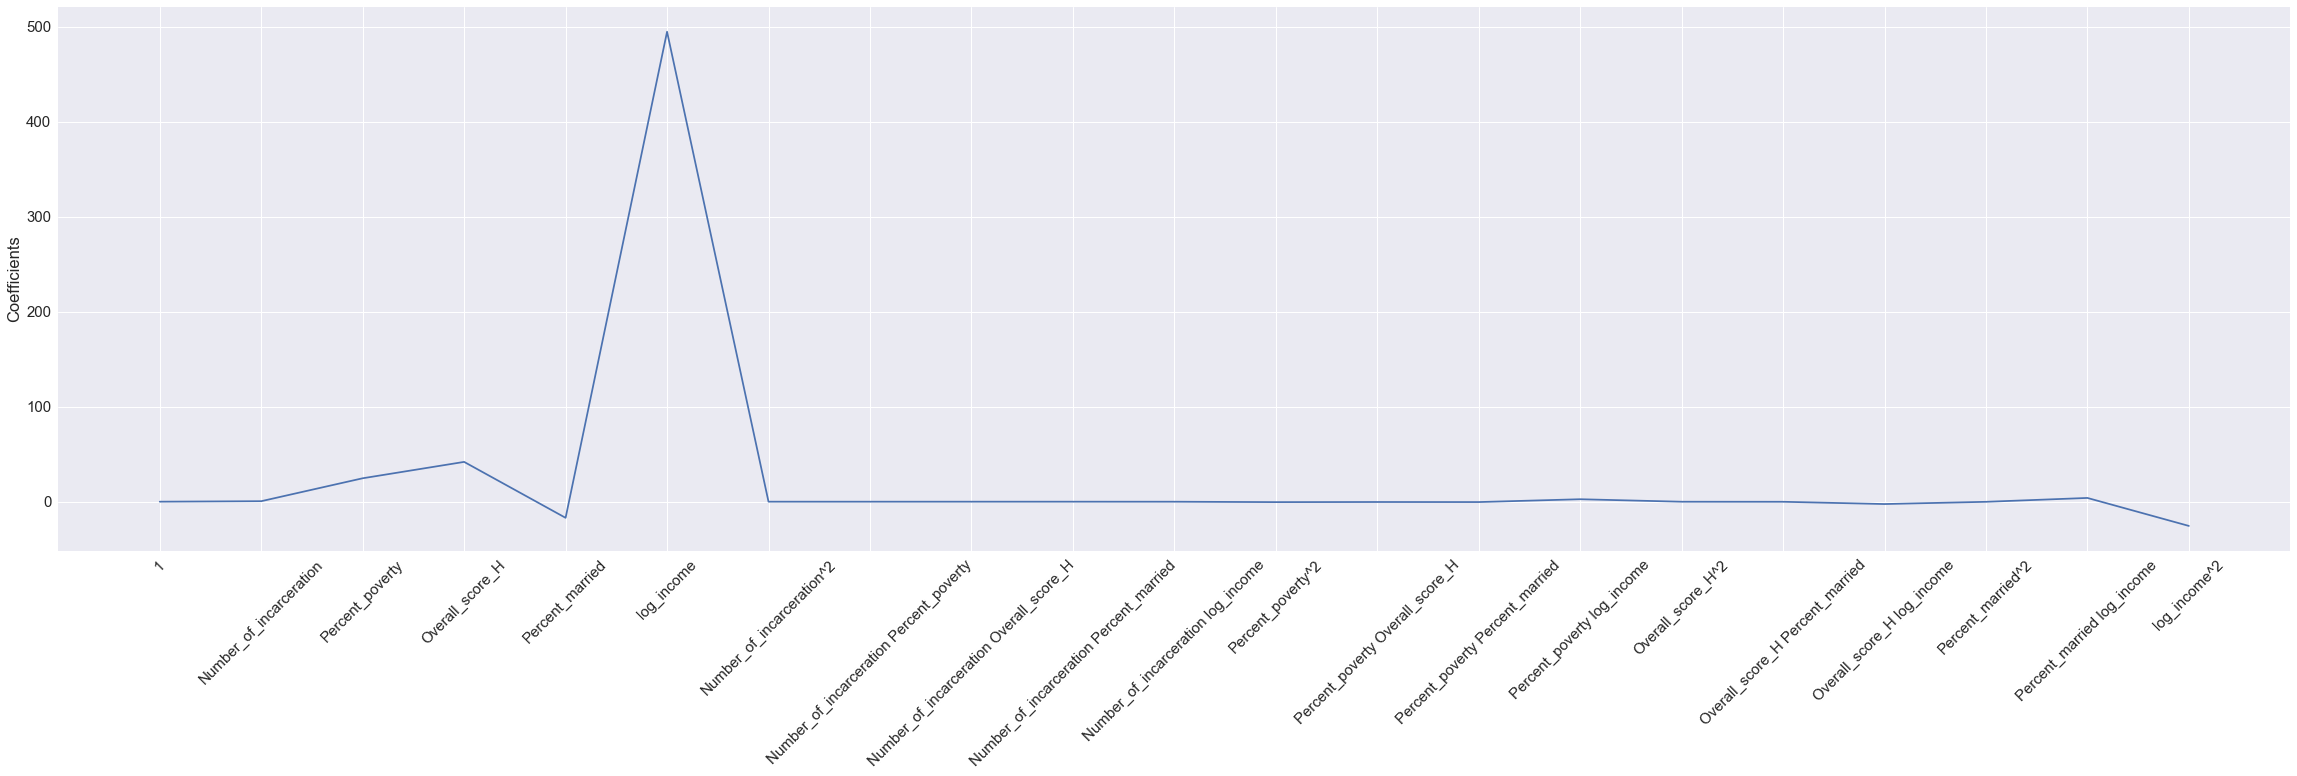

0.7218363321638482

In [293]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1e-5)

# plt.plot(np.arange(100),np.squeeze(model.coef_))
# plt.plot(np.arange(100),w_true)
# plt.legend(["Estimated","True"])
# plt.show()

ridge_coef = ridge.fit(x, y).coef_
_ = plt.figure(figsize=(40,10))
_ = plt.plot(range(len(x.columns)), ridge_coef)
_ = plt.xticks(range(len(x.columns)), x.columns, rotation=45)
_ = plt.ylabel('Coefficients')

plt.show()
ridge.score(x,y)

## Lasso analysis

In [301]:
from sklearn.linear_model import Lasso

#alphas = [5e-3, 2e-2]
#for i in alphas:
    

lasso = Lasso(alpha=1e-4)
lasso_coef = lasso.fit(x_train, y_train).coef_
_ = plt.figure(figsize=(40,10))
_ = plt.plot(range(len(x.columns)), lasso_coef)
_ = plt.xticks(range(len(x.columns)), x.columns, rotation=45)
_ = plt.ylabel('Coefficients')

plt.show()
lasso.score(x_test,y_test)

NameError: name 'x_train' is not defined

## ElasticNet analysis

In [299]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=1e-4)
elastic_coef = elastic.fit(x, y).coef_
_ = plt.figure(figsize=(40,10))
_ = plt.plot(range(len(x.columns)), lasso_coef)
_ = plt.xticks(range(len(x.columns)), x.columns, rotation=45)
_ = plt.ylabel('Coefficients')

plt.show()
lasso.score(x,y)

en = ElasticNet(1e-9)
en.fit(X_train,y_train)

en.score(X_test,y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.21835593064390557

## ElasticNetCV analysis

In [286]:
from sklearn.linear_model import ElasticNetCV
ela = ElasticNetCV(l1_ratio = .2)
ela.fit(X_train, y_train)

ela.score(X_test,y_test)

0.10497767782431022

# Summary of results

Steps

# Next Steps

Steps

# Appendix

Random code dump

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
result_index = result_mod.set_index('State').

In [ ]:
p = PolynomialFeatures(degree=2).fit(result_index)
print(p.get_feature_names(result_index.columns))
features = pd.DataFrame(p.transform(result_index), columns=p.get_feature_names(result_index.columns))
features

In [ ]:
features.corr()

In [ ]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Overall_score ~ Salary + Income + Number_of_incarceration + Percent_SMI + Percent_poverty+Overall_score_H + Percent_married', data=result1, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()